In [38]:
from __future__ import print_function

import argparse
import codecs
import logging
import time

import numpy as np
import tqdm

from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.datasets.movielens import get_movielens
from implicit.lmf import LogisticMatrixFactorization
from implicit.nearest_neighbours import (
    BM25Recommender,
    CosineRecommender,
    TFIDFRecommender,
    bm25_weight,
)

log = logging.getLogger("implicit")
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def calculate_similar_movies(output_filename, model_name="als", min_rating=4.0, variant="20m"):
    # read in the input data file
    start = time.time()
    titles, ratings = get_movielens(variant)

    # remove things < min_rating, and convert to implicit dataset
    # by considering ratings as a binary preference only
    ratings.data[ratings.data < min_rating] = 0
    ratings.eliminate_zeros()
    ratings.data = np.ones(len(ratings.data))

    log.info("read data file in %s", time.time() - start)

    # generate a recommender model based off the input params
    if model_name == "als":
        model = AlternatingLeastSquares()

        # lets weight these models by bm25weight.
        log.debug("weighting matrix by bm25_weight")
        ratings = (bm25_weight(ratings, B=0.9) * 5).tocsr()

    elif model_name == "bpr":
        model = BayesianPersonalizedRanking()

    elif model_name == "lmf":
        model = LogisticMatrixFactorization()

    elif model_name == "tfidf":
        model = TFIDFRecommender()

    elif model_name == "cosine":
        model = CosineRecommender()

    elif model_name == "bm25":
        model = BM25Recommender(B=0.2)

    else:
        raise NotImplementedError("TODO: model %s" % model_name)

    # train the model
    log.debug("training model %s", model_name)
    start = time.time()
    model.fit(ratings)
    log.debug("trained model '%s' in %s", model_name, time.time() - start)
    log.debug("calculating top movies")

    user_count = np.ediff1d(ratings.indptr)
    to_generate = sorted(np.arange(len(titles)), key=lambda x: -user_count[x])

    log.debug("calculating similar movies")
    with tqdm.tqdm(total=len(to_generate)) as progress:
        with codecs.open(output_filename, "w", "utf8") as o:
            for movieid in to_generate:
                # if this movie has no ratings, skip over (for instance 'Graffiti Bridge' has
                # no ratings > 4 meaning we've filtered out all data for it.
                if ratings.indptr[movieid] != ratings.indptr[movieid + 1]:
                    title = titles[movieid]
                    for other, score in model.similar_items(movieid, 11):
                        o.write("%s\t%s\t%s\n" % (title, titles[other], score))
                progress.update(1)


In [4]:
titles, ratings = get_movielens("100k")

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

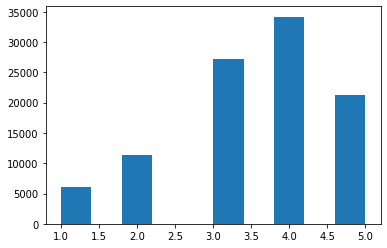

In [15]:
plt.hist(ratings.data)

In [18]:
model = AlternatingLeastSquares(64)

In [19]:
model.fit(ratings)

In [20]:
user_count = np.ediff1d(ratings.indptr)

In [23]:
to_generate = sorted(np.arange(len(titles)), key=lambda x: -user_count[x])

In [26]:
outfil = "test_movie.csv"

In [28]:
with tqdm.tqdm(total=len(to_generate)) as progress:
        with codecs.open(outfil, "w", "utf8") as o:
            for movieid in to_generate:
                # if this movie has no ratings, skip over (for instance 'Graffiti Bridge' has
                # no ratings > 4 meaning we've filtered out all data for it.
                if ratings.indptr[movieid] != ratings.indptr[movieid + 1]:
                    title = titles[movieid]
                    for other, score in model.similar_items(movieid, 11):
                        o.write("%s\t%s\t%s\n" % (title, titles[other], score))
                progress.update(1)

100%|██████████| 1683/1683 [00:00<00:00, 3757.59it/s]


In [30]:
model.item_factors.shape

(1683, 64)

In [39]:
scs = np.matmul(model.item_factors, model.user_factors.T)

In [45]:
np.min(scs)

-1.0765804

In [53]:
model.item_norms[2]

0.12124813

In [54]:
np.linalg.norm(model.item_factors[2, ])

0.12124813